In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print("✓ All libraries imported successfully!")

Matplotlib is building the font cache; this may take a moment.


PyTorch version: 2.9.1
Using device: CPU
✓ All libraries imported successfully!


100%|██████████| 9.91M/9.91M [00:19<00:00, 520kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 81.0kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 728kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.82MB/s]


Training samples: 60000
Test samples: 10000


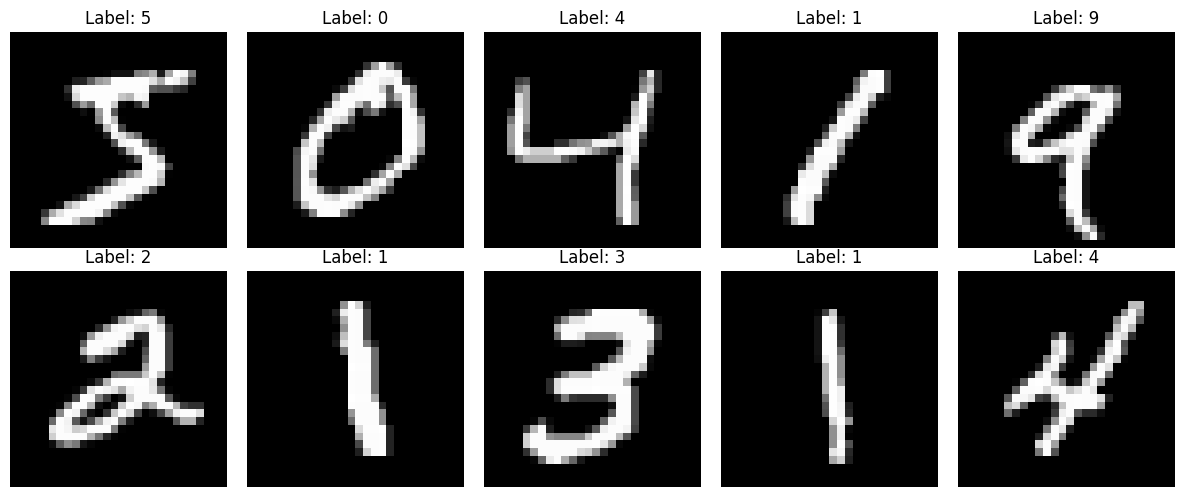

✓ Data loaded! You should see 10 digit images above


In [2]:
# Download MNIST dataset (handwritten digits 0-9)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# This will download ~10MB of data
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print("✓ Data loaded! You should see 10 digit images above")

In [3]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers - extract features from images
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # 1 input channel (grayscale), 32 output channels
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        
        # Dropout for regularization (prevents overfitting)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layers - make final classification
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 outputs (digits 0-9)

    def forward(self, x):
        # Pass data through the network
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Create the model
model = DigitClassifier()
print(model)
print(f"\n✓ Model created with {sum(p.numel() for p in model.parameters())} parameters")

DigitClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

✓ Model created with 1199882 parameters


In [4]:
# Create data loaders (batches of data for training)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Loss function - measures how wrong the predictions are
criterion = nn.CrossEntropyLoss()

# Optimizer - adjusts model weights to reduce loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✓ Ready to train!")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


✓ Ready to train!
Training batches: 938
Test batches: 10


In [5]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        
        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return avg_loss, accuracy

# Test function
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

print("✓ Training functions defined!")

✓ Training functions defined!


Starting training...

Epoch 1/3
  Batch 0/938, Loss: 2.3376
  Batch 100/938, Loss: 0.4390
  Batch 200/938, Loss: 0.0844
  Batch 300/938, Loss: 0.1427
  Batch 400/938, Loss: 0.0382
  Batch 500/938, Loss: 0.0960
  Batch 600/938, Loss: 0.0504
  Batch 700/938, Loss: 0.1812
  Batch 800/938, Loss: 0.0658
  Batch 900/938, Loss: 0.0795
  Train Loss: 0.2007, Train Accuracy: 93.84%
  Test Loss: 0.0464, Test Accuracy: 98.51%

Epoch 2/3
  Batch 0/938, Loss: 0.0989
  Batch 100/938, Loss: 0.0475
  Batch 200/938, Loss: 0.3783
  Batch 300/938, Loss: 0.0366
  Batch 400/938, Loss: 0.0531
  Batch 500/938, Loss: 0.1096
  Batch 600/938, Loss: 0.1017
  Batch 700/938, Loss: 0.0044
  Batch 800/938, Loss: 0.0339
  Batch 900/938, Loss: 0.0804
  Train Loss: 0.0846, Train Accuracy: 97.54%
  Test Loss: 0.0322, Test Accuracy: 98.90%

Epoch 3/3
  Batch 0/938, Loss: 0.0401
  Batch 100/938, Loss: 0.0725
  Batch 200/938, Loss: 0.0265
  Batch 300/938, Loss: 0.1651
  Batch 400/938, Loss: 0.0547
  Batch 500/938, Loss: 0.0

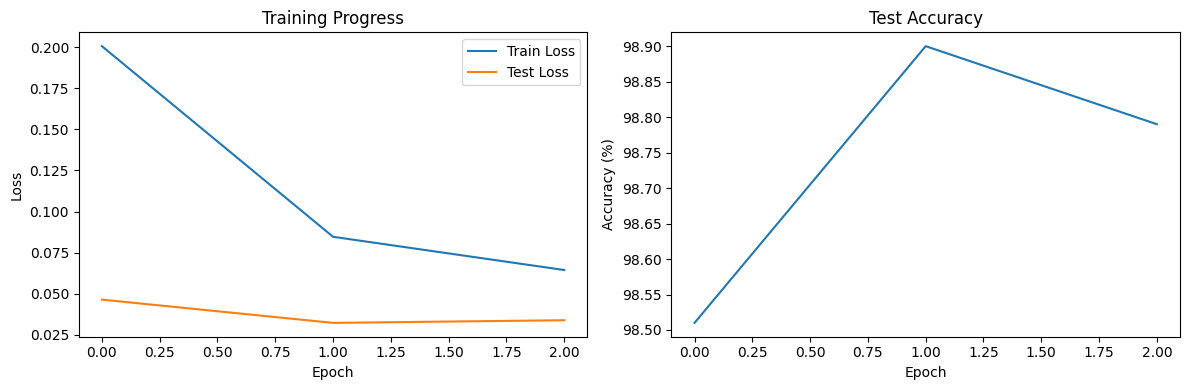

In [6]:
# Train for 3 epochs
num_epochs = 3
train_losses = []
test_losses = []
test_accuracies = []

print("Starting training...\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    
    # Test
    test_loss, test_acc = test(model, test_loader, criterion)
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%\n")
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

print(f"✓ Training complete! Final test accuracy: {test_accuracies[-1]:.2f}%")

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.tight_layout()
plt.show()

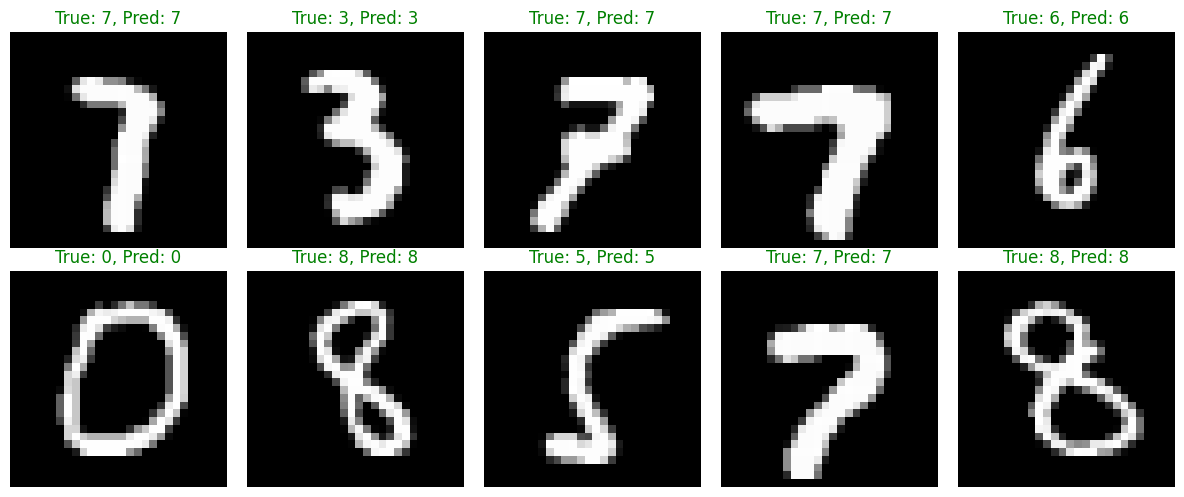

✓ Green = correct prediction, Red = wrong prediction


In [7]:
# Test on random examples
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        idx = np.random.randint(len(test_dataset))
        image, true_label = test_dataset[idx]
        
        # Get prediction
        output = model(image.unsqueeze(0))
        pred_label = output.argmax(dim=1).item()
        
        # Display
        ax.imshow(image.squeeze(), cmap='gray')
        color = 'green' if pred_label == true_label else 'red'
        ax.set_title(f'True: {true_label}, Pred: {pred_label}', color=color)
        ax.axis('off')

plt.tight_layout()
plt.show()
print("✓ Green = correct prediction, Red = wrong prediction")

In [8]:
# Save the trained model
torch.save(model.state_dict(), 'digit_classifier.pth')
print("✓ Model saved as 'digit_classifier.pth'")

✓ Model saved as 'digit_classifier.pth'
